# Semantic Segmentation of Aerial Imagery with Raster Vision 
## Part 4: Exploring the Dataset and Problem Space

This tutorial series walks through an example of using [Raster Vision](https://rastervision.io/) to train a deep learning model to identify buildings in satellite imagery.</br>

*Primary Libraries and Tools*:

|Name|Description|Link|
|-|-|-|
| `Raster Vision ` | Library and framework for geospatial semantic segmentation, object detection, and chip classification with python| https://rastervision.io/ |
| `Apptainer` | Containerization software that allows for transportable and reproducible software |https://apptainer.org/ |
| `pandas` | Dataframes and other datatypes for data analysis and manipulation | https://pandas.pydata.org/ |
| `geopandas` | Extends datatypes used by pandas to allow spatial operations on geometric types | https://geopandas.org/en/stable/ |
| `rioxarray` | Data structures and routines for working with gridded geospatial data | https://github.com/corteva/rioxarray |
| `plotnine` | A plotting library for Python modeled after R's [ggplot2](https://ggplot2.tidyverse.org/) | https://plotnine.readthedocs.io/en/v0.12.3/ |
| `pathlib` | A Python library for handling files and paths in the filesystem | https://docs.python.org/3/library/pathlib.html |

*Prerequisites*:
  * Basic understanding of navigating the Linux command line, including navigating among directories and editing text files
  * Basic python skills, including an understanding of object-oriented programming, function calls, and basic data types
  * Basic understanding of shell scripts and job scheduling with SLURM for running code on Atlas
  * A SCINet account for running this tutorial on Atlas
  * **Completion of tutorial parts 1-3 of this series**

*Tutorials in this Series*:
  * 1\. **Tutorial Setup on SCINet**
  * 2\. **Overview of Deep Learning for Imagery and the Raster Vision Pipeline**
  * 3\. **Constructing and Exploring the Apptainer Image**
  * 4\. **Exploring the Dataset and Problem Space <span style="color: red;">_(You are here)_</span>**
  * 5\. **Overview of Raster Vision Model Configuration and Setup**
  * 6\. **Breakdown of Raster Vision Code Version 1**
  * 7\. **Evaluating Training Performance and Visualizing Predictions**
  * 8\. **Modifying Model Configuration - Covering Entire Prediction Space**
  * 9\. **Modifying Model Configuration - Data Augmentation**
  * 10\. **Modifying Model Configuration - Hyperparameter Tuning**

## Exploring the dataset and problem space
This tutorial series is based on Raster Vision's [quickstart](https://docs.rastervision.io/en/0.30/framework/quickstart.html). The goal of this project is to create a semantic segmentation model to identify buildings in satellite imagery.

We'll begin by exploring our data and gaining an understanding of the problem we are trying to solve. We will use data from the [SpaceNet](https://spacenet.ai/) project, which includes high-resolution aerial photos of Las Vegas, Nevada, and polygon labels that define the locations of each building in each image. More information about the images [is available here](https://spacenet.ai/spacenet-buildings-dataset-v2/). The goal of this project is to train a deep learning model to classify each pixel in an image as "building" or "non-building".

As a preliminary step, run the cells below to import all required packages and to define functions we will need for imagery visualization.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
from rasterio.enums import Resampling
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import os
import json

/apps/python-3.9.2/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


The following function allows us to visualize our label data superimposed over our satellite rasters.

In [2]:
# We have 3 bands of data, and our image is 650 x 650 pixels
# The RGB values are not in a standard range (ie [0,1] or [0,255]), so we must scale them accordingly
def plot_raster_vector(raster, vector):
    raster_min = raster.min(dim=['x','y'])
    raster_max = raster.max(dim=['x','y'])
    raster_scaled = (raster - raster_min)/(raster_max - raster_min)
    
    fig, ax = plt.subplots(figsize=(10,10))
    raster_scaled.plot.imshow(ax=ax)
    vector.boundary.plot(ax=ax, linewidth=3)

### Exploring the aerial imagery

We are using 1060 geoTIFF images that are 650 by 650 pixels in size. These images are split into three sets: 1000 are for trianing, 50 are for validation, and 10 are for testing. These images were randomly selected from SpaceNet's Las Vegas building detection dataset. Each image file has a unique ID in the file name that we use to match it with the associated vector file. Here we will visualize one of the images in our validation dataset, and the vector data representing building outlines.

In [3]:
# Define the location of the training data set
data_dir = Path('/reference/workshops/rastervision/input/train')

In [4]:
# Show the names of the first 5 image files in the dataset.
[p.name for p in sorted((data_dir).glob('*.tif'))][:5]

['RGB-PanSharpen_AOI_2_Vegas_img1004.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img101.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img1015.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img1017.tif',
 'RGB-PanSharpen_AOI_2_Vegas_img1018.tif']

In [5]:
# Show the names of the first 5 vector files in the dataset.
[p.name for p in sorted((data_dir).glob('*.geojson'))][:5]

['buildings_AOI_2_Vegas_img1004.geojson',
 'buildings_AOI_2_Vegas_img101.geojson',
 'buildings_AOI_2_Vegas_img1015.geojson',
 'buildings_AOI_2_Vegas_img1017.geojson',
 'buildings_AOI_2_Vegas_img1018.geojson']

In [8]:
# Open and explore one of the images from the dataset
file_index = 10 # Which raster/vector files in the sorted lists to choose
raster_filename = [p.name for p in sorted((data_dir).glob('*.tif'))][10]
print("Image file name: ", raster_filename)
rdata = rioxarray.open_rasterio(data_dir / raster_filename)
print("Image shape: ", rdata.shape)
print("Image CRS: ", rdata.rio.crs)

Image file name:  RGB-PanSharpen_AOI_2_Vegas_img1053.tif
Image shape:  (3, 650, 650)
Image CRS:  EPSG:4326


In [9]:
# Open and explore the associated vector data
vector_filename = [p.name for p in sorted((data_dir).glob('*.geojson'))][10]
print("Vector file name: ", vector_filename)
vdata = gpd.read_file(data_dir / vector_filename)
print("Number of polygons in file: ", len(vdata))
print("Vector data CRS: ", vdata.crs)

Vector file name:  buildings_AOI_2_Vegas_img1053.geojson
Number of polygons in file:  40
Vector data CRS:  epsg:4326


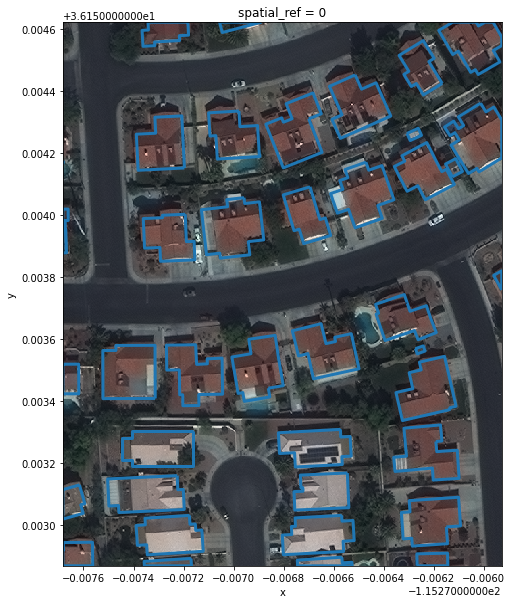

In [10]:
plot_raster_vector(rdata, vdata)

**Excercise:** Take a look at some of the other images in the dataset to get a better feel for the problem space. You can do this by modifying the `file_index` value above.

#### Project goal
We would like to build a model that can receive a satellite image, and return a raster of the same size where each pixel is coded with a prediction of "building" or "background". Raster Vision is a good tool for this project because:
- We already have a large dataset we can train on
- Our satellite images are in RGB, so we can easily perform transfer learning from other models built on RGB data
- We wish to perform semantic segmentation, which is one of the three deep learning tasks Raster Vision supports

#### Conclusion
Now you should understand what problem we are trying to solve, and how Raster Vision is a good fit for this particular problem. In the next tutorial, we will start to explore how we interact with Raster Vision, and what classes Raster Vision provides.